In [17]:
%matplotlib inline


# Neural network regression

In this example, we will train a deep network to fit a simple 1D function, and evaluate the impact of the architecture and optimizer.

## Generating a dataset

We create a synthetic dataset. The true generative process will take a 1-D
vector and compute its sine.


In [18]:
import numpy as np

rng = np.random.RandomState(0)
data = np.linspace(0, 12, num=1_000).reshape(-1, 1)
target = np.sin(data).ravel()

Now, we can imagine a scenario where we get observations from this true
process. However, we will add some challenges:

- the measurements will be noisy;
- only samples from the beginning of the signal will be available.



# Dataloader
We first need to define a Torch dataset that encapsules our generative process. We can create a our custom dataset by inheriting from the class `torch.utils.data.dataset.Dataset`

In [19]:
import torch
from torch.utils.data.dataset import Dataset

class CustomDataset(Dataset):
    def __init__(self, data, target, n, noise_std=.05):
        training_sample_indices = rng.choice(np.arange(0, 400), size=n, replace=False)
        self.training_data = torch.Tensor(data[training_sample_indices])
        self.training_noisy_target = torch.Tensor(target[training_sample_indices] + noise_std * rng.randn(len(training_sample_indices)))
    def __getitem__(self, index):
        return (self.training_data[index], self.training_noisy_target[index])

    def __len__(self):
        return len(self.training_data)

Let's plot the true signal and the noisy measurements available for training.



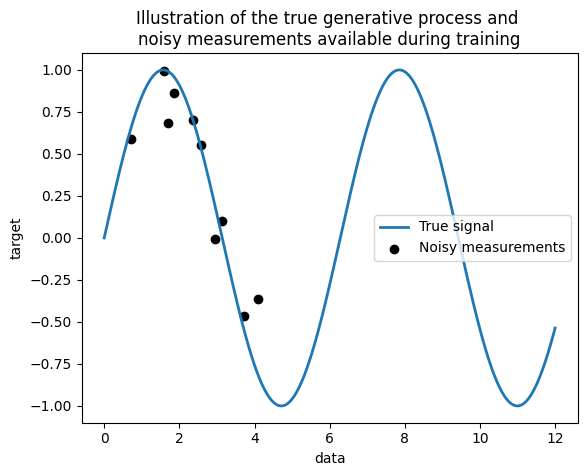

In [20]:
import matplotlib.pyplot as plt

dataset = CustomDataset(data, target, n=10, noise_std=0.2)
plt.plot(data, target, label="True signal", linewidth=2)
plt.scatter(
    dataset.training_data,
    dataset.training_noisy_target,
    color="black",
    label="Noisy measurements",
)
plt.legend()
plt.xlabel("data")
plt.ylabel("target")
_ = plt.title(
    "Illustration of the true generative process and \n"
    "noisy measurements available during training"
)

## Defining a neural network
First, we would like to highlight the limitations of a linear model given
our dataset. If we don't use any non-linear functions, the neural network can only learn a linear function. We start by defining the neural network function using the torch.nn.Module



Tensor Size:

[B, C, H, W]
B = size of minibatch
C = colours/channels
H = height of the image
W = width of the image

[B, C, D]
B = size of minibatch
C = channels
D = length of the audio

in our example
[B, d]
B = size of the minibatch
d = size of the input (=1)

In [21]:
class LinearNet(torch.nn.Module):
    def __init__(self, hidden_features = 1000):
        super().__init__()
        self.layer1 = torch.nn.Linear(1, hidden_features)
        self.layer2 = torch.nn.Linear(hidden_features, 1)

    def forward(self, x):
        features = self.layer1(x)
        out = self.layer2(features)
        return out.squeeze(1)


Training the network requires defining a dataloader `torch.utils.data.DataLoader`, an optimizer `torch.optim.SGD` and performing a loop over mini-batches of training data.
We'll do so and plot the training loss as a function of the epochs in order to make sure that we are actually minising the empirical risk!


Text(0, 0.5, 'training loss')

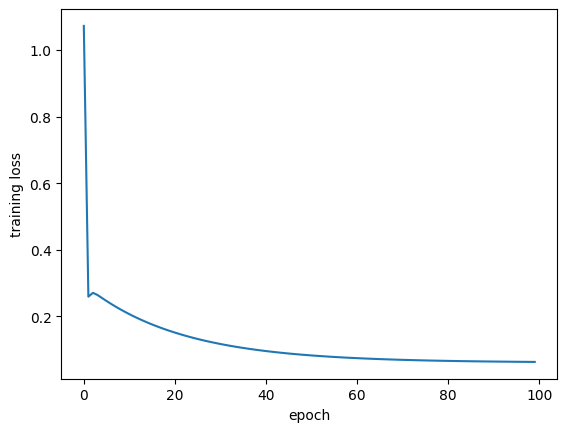

In [22]:
net = LinearNet()

criterion = torch.nn.MSELoss()
epochs = 100
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4)

optimizer = torch.optim.SGD(net.parameters(), lr=.0001, weight_decay=0)

losses = []
for ep in range(epochs):
    err = []
    for i, (x,y) in enumerate(dataloader):
        loss = criterion(net(x), y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        err.append(loss.item())

    losses.append(np.mean(err))

plt.plot(losses)
plt.xlabel("epoch")
plt.ylabel("training loss")

Let's now inspect the learned (linear!) function

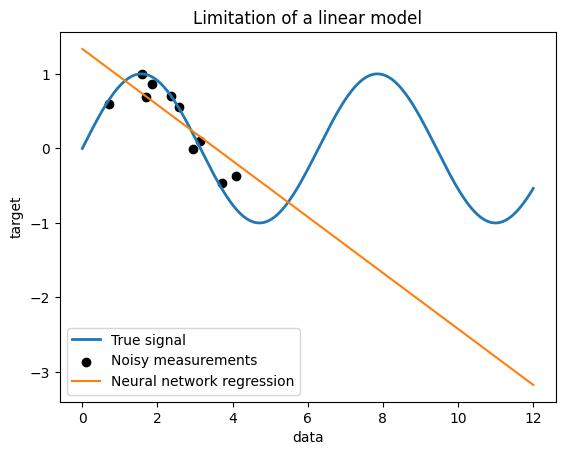

In [23]:
plt.plot(data, target, label="True signal", linewidth=2)
plt.scatter(
    dataset.training_data,
    dataset.training_noisy_target,
    color="black",
    label="Noisy measurements",
)
with torch.no_grad():
  plt.plot(data, net(torch.Tensor(data)), label="Neural network regression")
  plt.legend()
  plt.xlabel("data")
  plt.ylabel("target")
  _ = plt.title("Limitation of a linear model")

# Non-Linear Network

Let's now build and train a non-linear network by adding a relu activation.

In [24]:
class NonLinearNet(torch.nn.Module):
    def __init__(self, hidden_features = 1000):
        super().__init__()
        self.layer1 = torch.nn.Linear(1, hidden_features)
        self.layer2 = torch.nn.Linear(hidden_features, 1)

    def forward(self, x):
        features = self.layer1(x)
        features = torch.nn.functional.relu(features)
        out = self.layer2(features)
        return out.squeeze(1)


Text(0, 0.5, 'training loss')

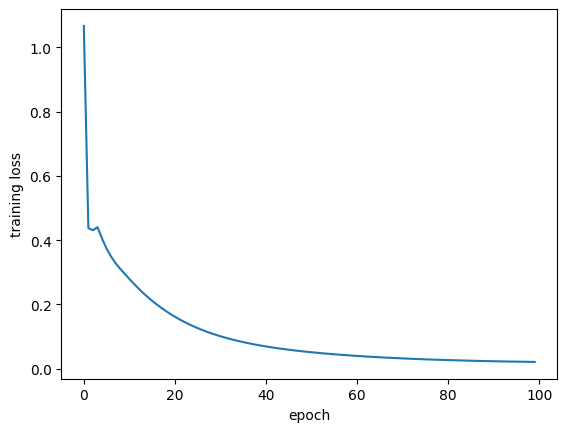

In [25]:
net = NonLinearNet()

criterion = torch.nn.MSELoss()
epochs = 100
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)

optimizer = torch.optim.Adam(net.parameters(), lr=.0001)

losses = []
for ep in range(epochs):
    err = []
    for i, (x,y) in enumerate(dataloader):
        loss = criterion(net(x), y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        err.append(loss.item())

    losses.append(np.mean(err))

plt.plot(losses)
plt.xlabel("epoch")
plt.ylabel("training loss")

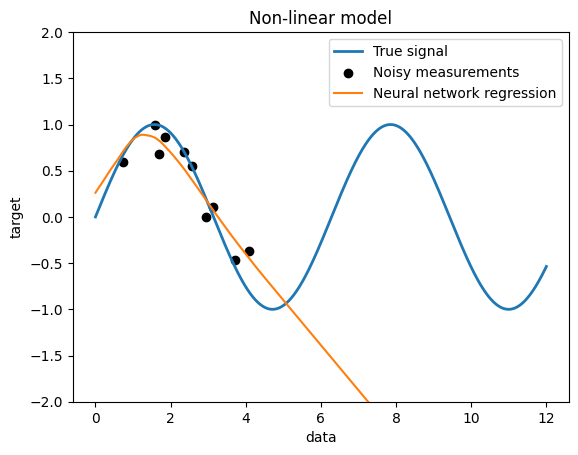

In [26]:
plt.plot(data, target, label="True signal", linewidth=2)
plt.scatter(
    dataset.training_data,
    dataset.training_noisy_target,
    color="black",
    label="Noisy measurements",
)
with torch.no_grad():
  plt.plot(data, net(torch.Tensor(data)), label="Neural network regression")
  plt.legend()
  plt.xlabel("data")
  plt.ylabel("target")
  plt.ylim((-2,2))
  _ = plt.title("Non-linear model")

# TODO List

* Change the optimizer to Adam and tune the hyperparameters
* Increase the noise to .5 and reduce the number of datapoints
* Evaluate the effect of the width of the network
* Build a deeper network
* Choose a periodic activation function (hint: sin)